In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pip install kaggle


In [ ]:
from google.colab import files
files.upload()  # Upload kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gemy26","key":"6ebc788179b827feb99bf86d3db7a4a3"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d hereisburak/pins-face-recognition -p /content


Dataset URL: https://www.kaggle.com/datasets/hereisburak/pins-face-recognition
License(s): CC0-1.0
 97% 361M/372M [00:02<00:00, 253MB/s]
100% 372M/372M [00:02<00:00, 176MB/s]


In [ ]:
!unzip /content/pins-face-recognition.zip -d /content


Streaming output truncated to the last 5000 lines.
  inflating: /content/105_classes_pins_dataset/pins_Sophie Turner/Sophie Turner37_964.jpg  
  inflating: /content/105_classes_pins_dataset/pins_Sophie Turner/Sophie Turner38_965.jpg  
  inflating: /content/105_classes_pins_dataset/pins_Sophie Turner/Sophie Turner39_966.jpg  
  inflating: /content/105_classes_pins_dataset/pins_Sophie Turner/Sophie Turner3_956.jpg  
  inflating: /content/105_classes_pins_dataset/pins_Sophie Turner/Sophie Turner41_968.jpg  
  inflating: /content/105_classes_pins_dataset/pins_Sophie Turner/Sophie Turner42_969.jpg  
  inflating: /content/105_classes_pins_dataset/pins_Sophie Turner/Sophie Turner44_970.jpg  
  inflating: /content/105_classes_pins_dataset/pins_Sophie Turner/Sophie Turner45_971.jpg  
  inflating: /content/105_classes_pins_dataset/pins_Sophie Turner/Sophie Turner46_972.jpg  
  inflating: /content/105_classes_pins_dataset/pins_Sophie Turner/Sophie Turner47_973.jpg  
  inflating: /content/105_clas

In [ ]:
!cp -r 105_classes_pins_dataset /content/drive/MyDrive/


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define dataset path in Google Drive
dataset_path = "/content/drive/MyDrive/105_classes_pins_dataset"
base_dir = "/content/processed_data"  # Directory to store train/val/test sets
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

def extract_class_name(file_path):
    folder_name = os.path.basename(os.path.dirname(file_path))
    return folder_name.split("_", 1)[-1]  # Remove the "pins_"

def organize_dataset(dataset_path, train_dir, val_dir, test_dir, test_size=0.2, val_size=0.2):
    all_files = []
    class_names = set()

    # Collect all file paths and class names
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(("jpg", "jpeg", "png")):
                file_path = os.path.join(root, file)
                all_files.append(file_path)
                class_names.add(extract_class_name(file_path))

    for class_name in class_names:
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Partition the data
    for class_name in class_names:
        class_files = [f for f in all_files if extract_class_name(f) == class_name]
        train_files, test_files = train_test_split(class_files, test_size=test_size, random_state=42)
        train_files, val_files = train_test_split(train_files, test_size=val_size, random_state=42)

        # Copy files to respective directories
        for file in train_files:
            shutil.copy(file, os.path.join(train_dir, class_name))
        for file in val_files:
            shutil.copy(file, os.path.join(val_dir, class_name))
        for file in test_files:
            shutil.copy(file, os.path.join(test_dir, class_name))

 


organize_dataset(dataset_path, train_dir, val_dir, test_dir)


In [ ]:
#print sample 

import os
import random

train_dir = "/content/processed_data/train"

classes = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

random_class = random.choice(classes)

class_dir = os.path.join(train_dir, random_class)
image_files = [f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

random_image = random.choice(image_files)
image_path = os.path.join(class_dir, random_image)

print(f"Class: {random_class}")
print(f"Image: {random_image}")
print(f"Path: {image_path}")


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load and preprocess data
train_dir = "./processed_data/train"
val_dir = "./processed_data/val"
test_dir = "./processed_data/test"

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')
val_data = val_test_datagen.flow_from_directory(val_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')
test_data = val_test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False)

base_model = Xception(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output_layer = Dense(train_data.num_classes, activation="softmax")(x)

# Define the model
xception_model = Model(inputs=base_model.input, outputs=output_layer)

for layer in base_model.layers:
    layer.trainable = False

# Compile the model
xception_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                       loss="categorical_crossentropy",
                       metrics=["accuracy"])

# Print model summary
xception_model.summary()

# Train
history = xception_model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    batch_size=32
)


112/112 ━━━━━━━━━━━━━━━━━━━━ 14s 123ms/step - accuracy: 0.2696 - loss: 3.0766
Test Accuracy: 0.23
112/112 ━━━━━━━━━━━━━━━━━━━━ 13s 115ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                        precision    recall  f1-score   support

          Adriana Lima       0.34      0.51      0.41        43
          Alex Lawther       0.17      0.32      0.22        31
    Alexandra Daddario       0.14      0.44      0.21        45
          Alvaro Morte       0.69      0.39      0.50        28
           Amanda Crew       0.09      0.08      0.09        24
          Andy Samberg       0.17      0.33      0.23        40
         Anne Hathaway       0.35      0.15      0.21        41
        Anthony Mackie       0.67      0.32      0.43        25
         Avril Lavigne       0.39      0.55      0.46        33
           Ben Affleck       0.23      0.19      0.21        26
            Bill Gates       0.57      0.68      0.62        25
          Bobby Morley       0.17      0.39      0.24        28
      Brenton Thwaites       0.15      0.19      0.17        42
        Brian J. Smith       0.25      0.10      0.14        21
           Brie Larson       0.33      

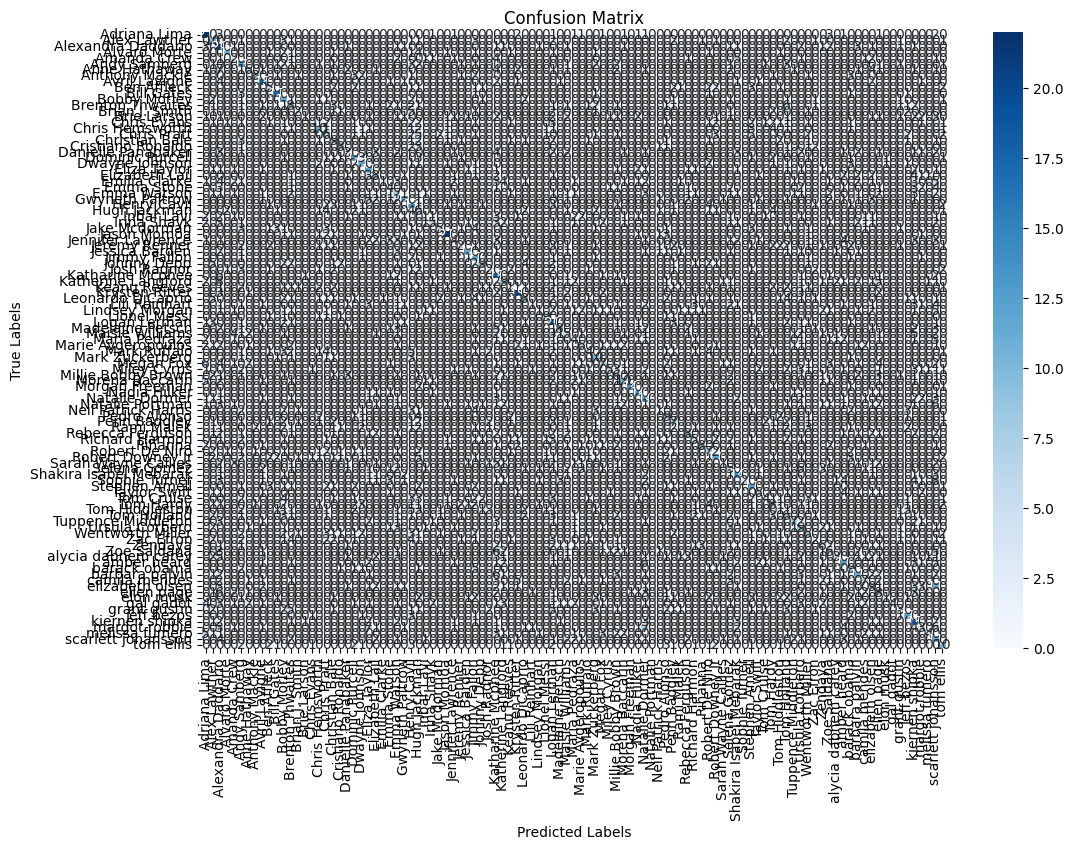

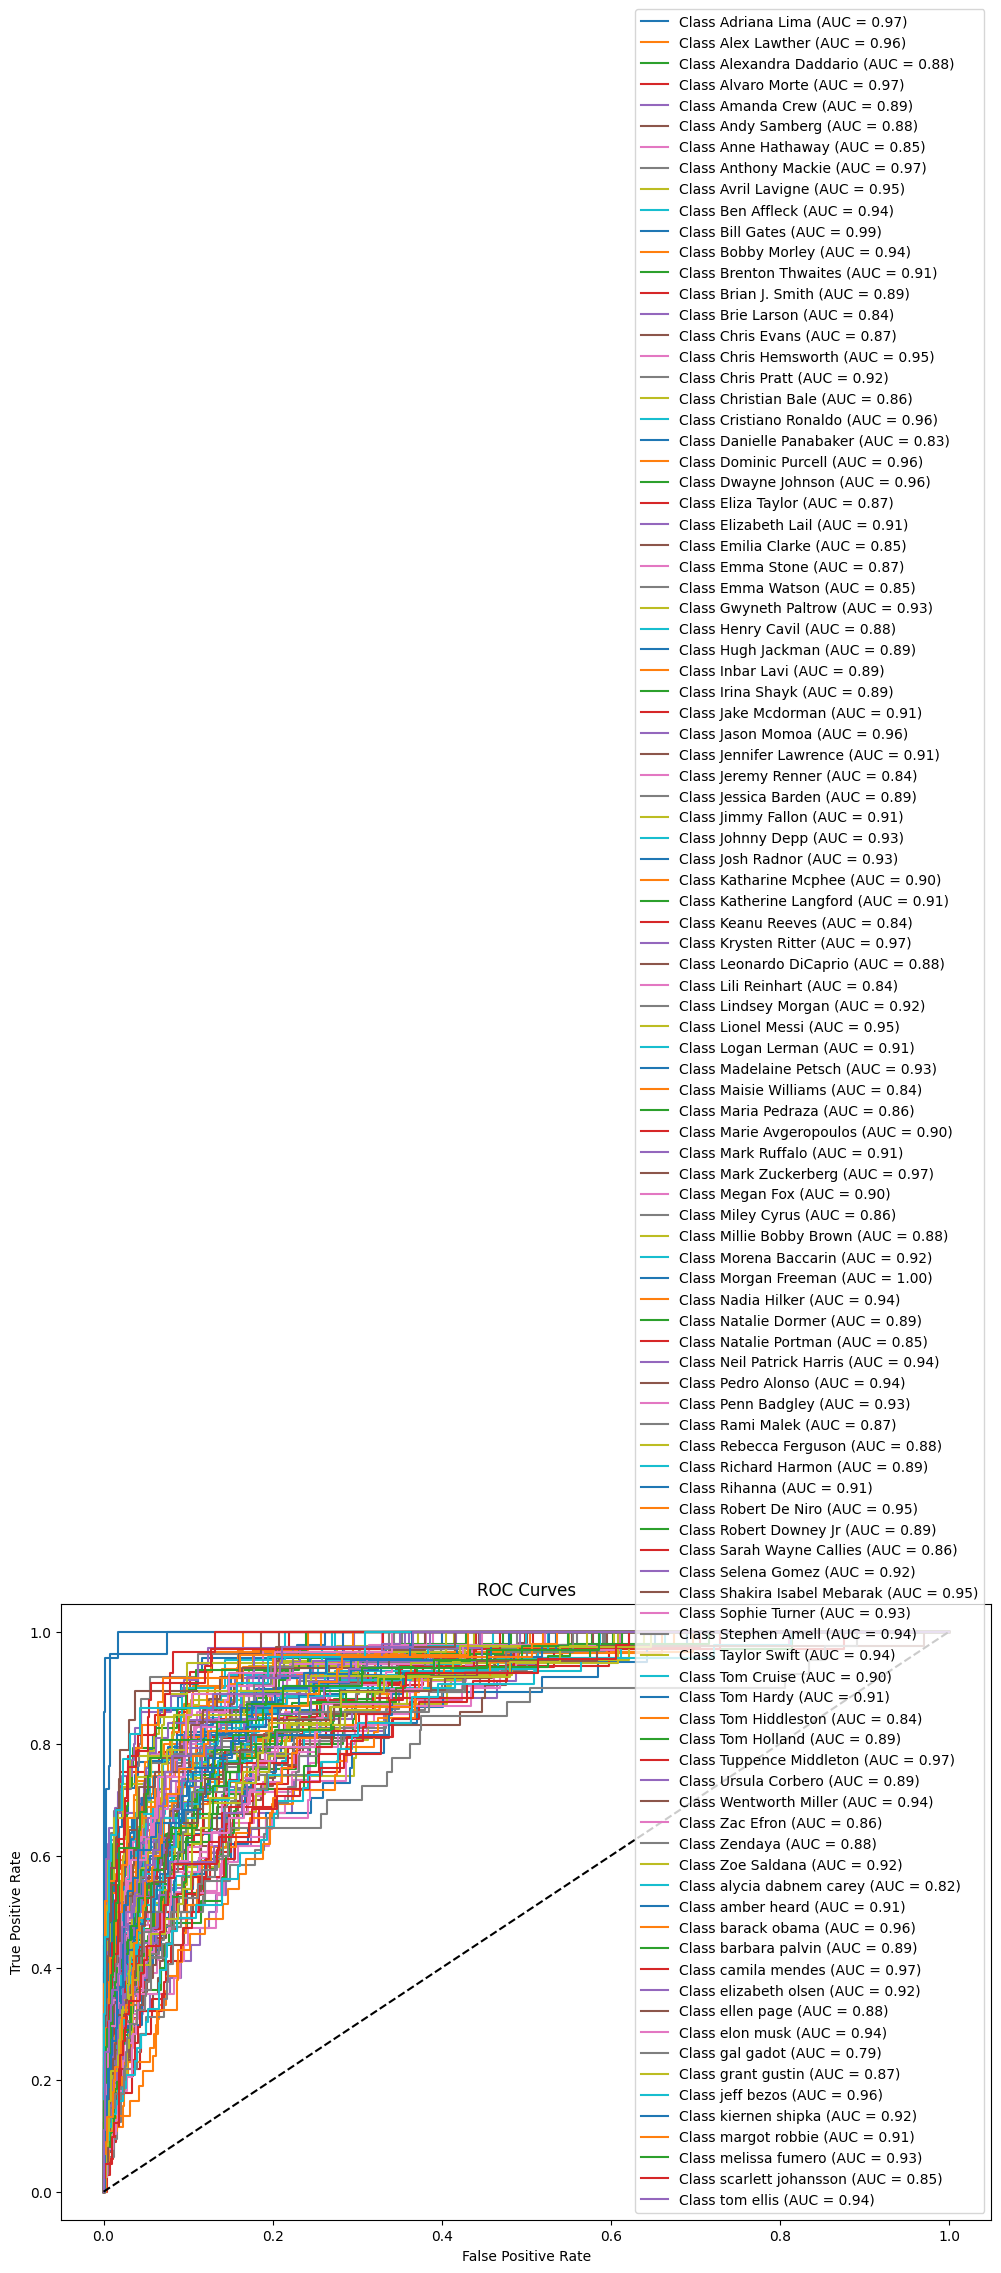

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = xception_model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Get predictions
y_true = test_data.classes  # True
y_pred_probs = xception_model.predict(test_data)  # Predicted
y_pred = np.argmax(y_pred_probs, axis=1)  # Predicted classes

#report
class_names = list(test_data.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# ROC and AUC
fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve((y_true == i).astype(int), y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(12, 8))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f"Class {class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(loc="lower right")
plt.show()



Selected Classes: ['kiernen shipka', 'Richard Harmon', 'Zoe Saldana', 'Logan Lerman', 'Stephen Amell', 'Alvaro Morte', 'Rihanna', 'Sophie Turner', 'Tuppence Middleton', 'Chris Hemsworth']
                    precision    recall  f1-score   support

    kiernen shipka       0.52      0.83      0.64        41
    Richard Harmon       0.61      0.57      0.59        30
       Zoe Saldana       0.67      0.68      0.68        38
      Logan Lerman       0.62      0.79      0.69        43
     Stephen Amell       0.75      0.84      0.79        32
      Alvaro Morte       0.95      0.64      0.77        28
           Rihanna       0.87      0.48      0.62        27
     Sophie Turner       0.85      0.54      0.66        41
Tuppence Middleton       0.75      0.67      0.71        27
   Chris Hemsworth       0.65      0.62      0.63        32

          accuracy                           0.68       339
         macro avg       0.72      0.67      0.68       339
      weighted avg       0.71 

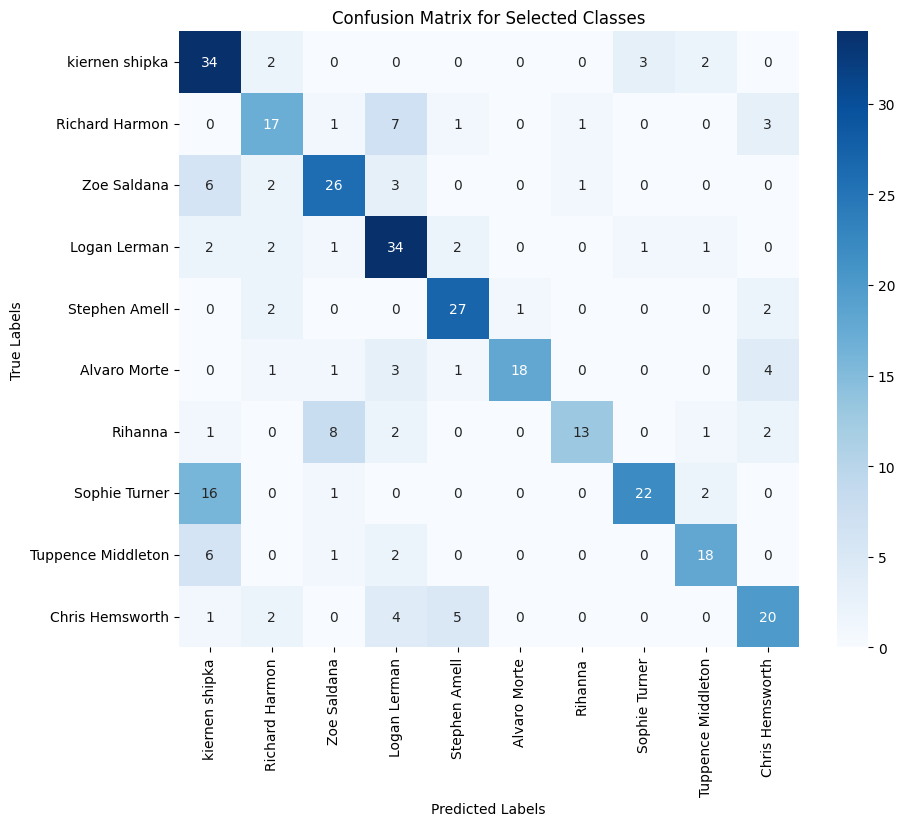

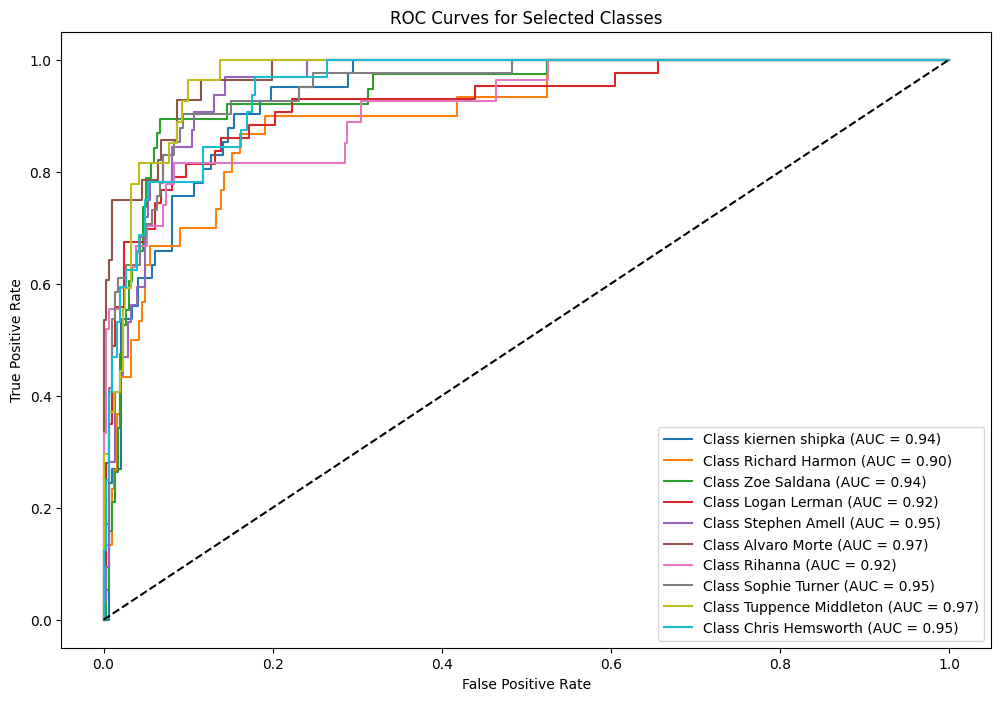

In [ ]:
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

#Select 10 Classes Randomly
all_classes = list(test_data.class_indices.keys())
selected_classes = random.sample(all_classes, 10)
selected_class_indices = [test_data.class_indices[class_name] for class_name in selected_classes]

mask = np.isin(y_true, selected_class_indices)
y_true_filtered = y_true[mask]  # True labels for selected classes
y_pred_probs_filtered = y_pred_probs[mask][:, selected_class_indices]  # Probabilities
y_pred_filtered = np.argmax(y_pred_probs_filtered, axis=1)  # Predict

class_mapping = {old: new for new, old in enumerate(selected_class_indices)}
y_true_filtered = np.array([class_mapping[label] for label in y_true_filtered])

y_pred_filtered = np.array([class_mapping[selected_class_indices[label]] for label in y_pred_filtered])

#Report
print(f"Selected Classes: {selected_classes}")
print(classification_report(y_true_filtered, y_pred_filtered, target_names=selected_classes))

#Confusion Matrix
conf_matrix = confusion_matrix(y_true_filtered, y_pred_filtered)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=selected_classes, yticklabels=selected_classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Selected Classes")
plt.show()

fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(selected_classes)):
    # Calculate ROC
    fpr[i], tpr[i], _ = roc_curve((y_true_filtered == i).astype(int), y_pred_probs_filtered[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(12, 8))
for i in range(len(selected_classes)):
    plt.plot(fpr[i], tpr[i], label=f"Class {selected_classes[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Selected Classes")
plt.legend(loc="lower right")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
The predicted class is: Cristiano Ronaldo


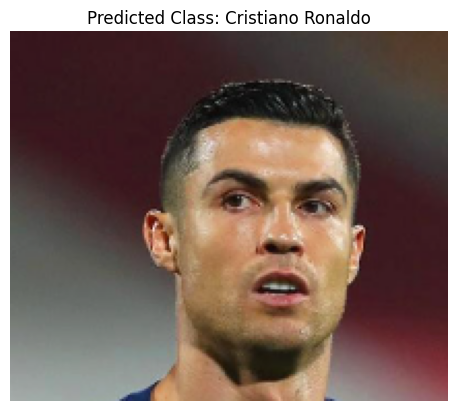

In [ ]:
from tensorflow.keras.preprocessing import image
test_image_path = "/content/cr72.png"
def preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def predict_image(model, image_array, class_indices):
    predictions = model.predict(image_array)
    predicted_index = np.argmax(predictions)
    class_labels = {v: k for k, v in class_indices.items()}
    predicted_class = class_labels[predicted_index]
    return predicted_class

test_image_array = preprocess_image(test_image_path)

predicted_class = predict_image(xception_model, test_image_array, test_data.class_indices)

print(f"The predicted class is: {predicted_class}")

plt.imshow(image.load_img(test_image_path))
plt.title(f"Predicted Class: {predicted_class}")
plt.axis("off")
plt.show()

In [ ]:
import numpy as np

from tensorflow.keras.preprocessing import image
test_image_path = "/content/Nasr.png"
def preprocess_image(image_path, target_size=(224, 224)):
    # Load the image
    img = image.load_img(image_path, target_size=target_size)  # Resize to model input size
    img_array = image.img_to_array(img)  # Convert to NumPy array
    img_array = img_array / 255.0  # Normalize pixel values to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Predict the class
def predict_image(model, image_array, class_indices):
    # Get predictions
    predictions = model.predict(image_array)
    predicted_index = np.argmax(predictions)  # Get the index of the highest probability
    # Map the predicted index to the class name
    class_labels = {v: k for k, v in class_indices.items()}  # Reverse the class_indices mapping
    predicted_class = class_labels[predicted_index]
    return predicted_class

# Preprocess the test image
test_image_array = preprocess_image(test_image_path)

# Predict the class of the image
predicted_class = predict_image(xception_model, test_image_array, test_data.class_indices)

# Display the result
print(f"The predicted class is: {predicted_class}")

# Show the image
plt.imshow(image.load_img(test_image_path))
plt.title(f"Predicted Class: {predicted_class}")
plt.axis("off")
plt.show()